# Проект "Прогнозирование температуры плавления стали"

# Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

# План работы

-*Подготовить данные. Изменить типы данных; определить и использовать номера партий, у которых есть замеры по температуре.*
-*Подготовка признаков. Составление единой таблицы со всеми данными для модели. Выделение целевого признака как последний замер в серии замеров. Поиск выбросов и их удаление. Проверка на наличие мультиколлинеарности. Разделение на features и target со смешиванием данных.*

Выбор моделей. Использование и обучение регрессионных моделей, например, CatBoostRegressor, LGBMRegressor и т.д.

Оценка эффективности моделей на тестовой выборке.

# Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

## Изучение данных

Используем функцию для просмотра значений внутри столбцов.

In [2]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].sort_values().unique())

Пройдемся по каждой таблице для анализа данных.

### Данные об электродах

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
show_rows(data_arc)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Начало нагрева дугой
['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-01 04:16:41' '2019-09-01 04:31:51' '2019-09-01 04:34:47']
Уникальные значения столбца Конец нагрева дугой
['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-01 04:19:45' '2019-09-01 04:32:48' '2019-09-01 04:36:08']
Уникальные значения столбца Активная мощность
[0.03000194 0.03018816 0.0301905  ... 3.15076178 3.15627646 3.73159611]
Уникальные значения столбца Реактивная мощность
[-7.15504924e+02  2.08063126e-02  2.11541653e-02 ...  2.45995915e+00
  2.50420606e+00  2.67638755e+00]


In [5]:
len(data_arc['key'].unique())

3214

In [6]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

<AxesSubplot:>

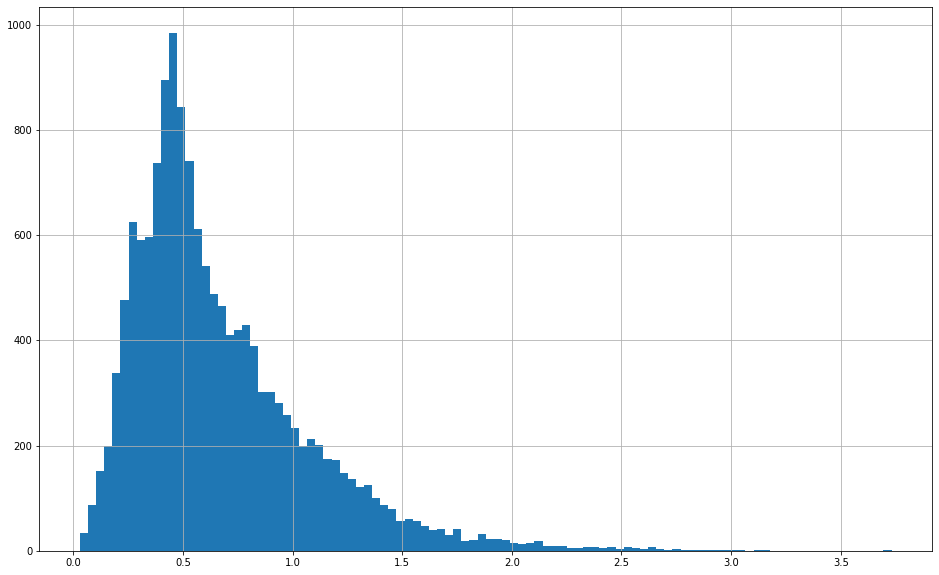

In [7]:
display(data_arc['Активная мощность'].describe())
data_arc['Активная мощность'].hist(bins=100, figsize=(16,10))

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64

<AxesSubplot:>

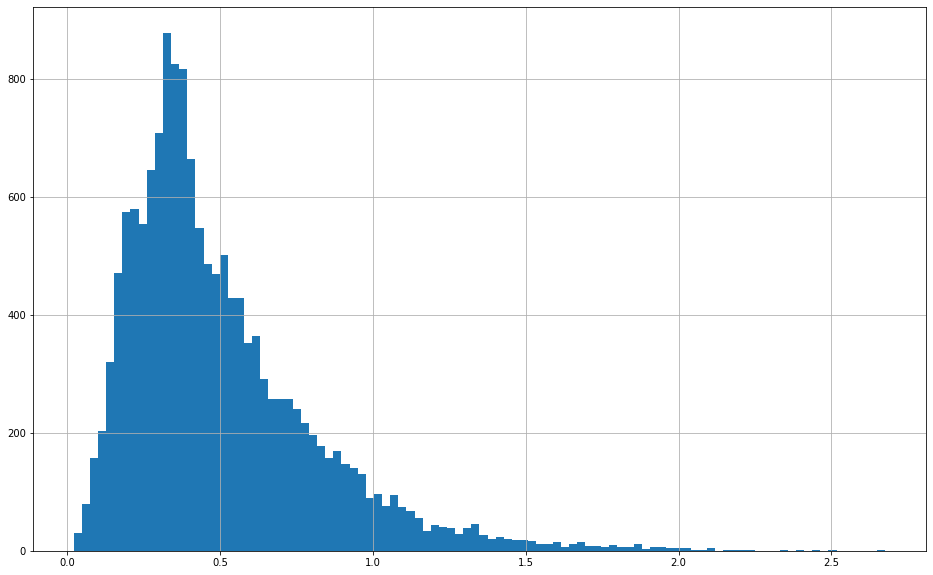

In [8]:
display(data_arc['Реактивная мощность'].describe())
display(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].describe())
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(16,10))

### Данные о подаче сыпучих материалов (объём)

In [9]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
show_rows(data_bulk)


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Уникальные значения столбца Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Уникальные значения столбца Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 1

In [11]:
len(data_bulk['key'].unique())

3129

In [12]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

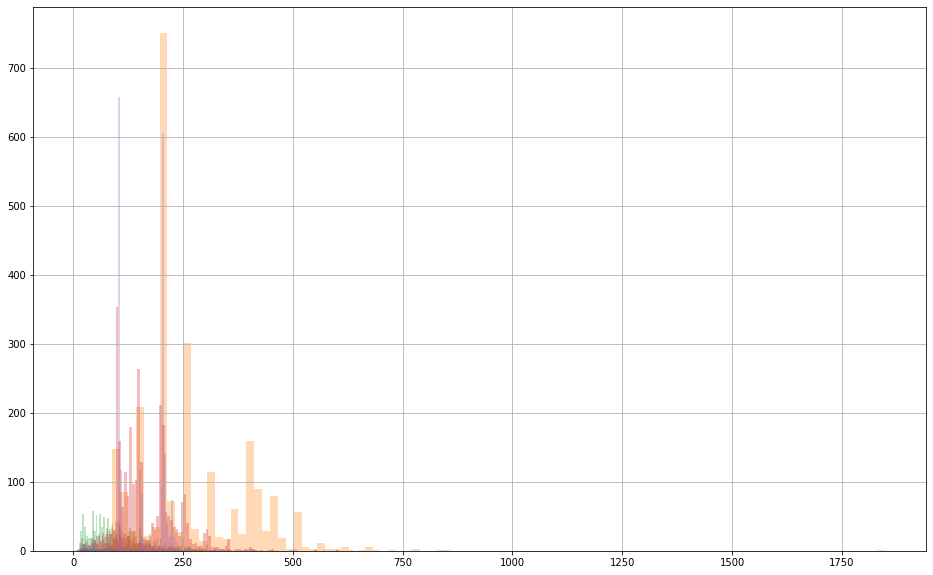

In [13]:
for column in data_bulk.columns:
    if column[0] == 'B':
        print(column)
        display(data_bulk[column].describe())
        data_bulk[column].hist(bins=100, figsize=(16,10), alpha=0.3)

### Данные о подаче сыпучих материалов (время)

In [14]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
show_rows(data_bulk_time)


Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Bulk 1
['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52:57' '20

In [16]:
len(data_bulk_time['key'].unique())

3129

In [17]:
data_bulk_time['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

### Данные о продувке сплава газом

In [18]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
show_rows(data_gas)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Газ 1
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


In [20]:
len(data_gas['key'].unique())

3239

In [21]:
data_gas['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

<AxesSubplot:>

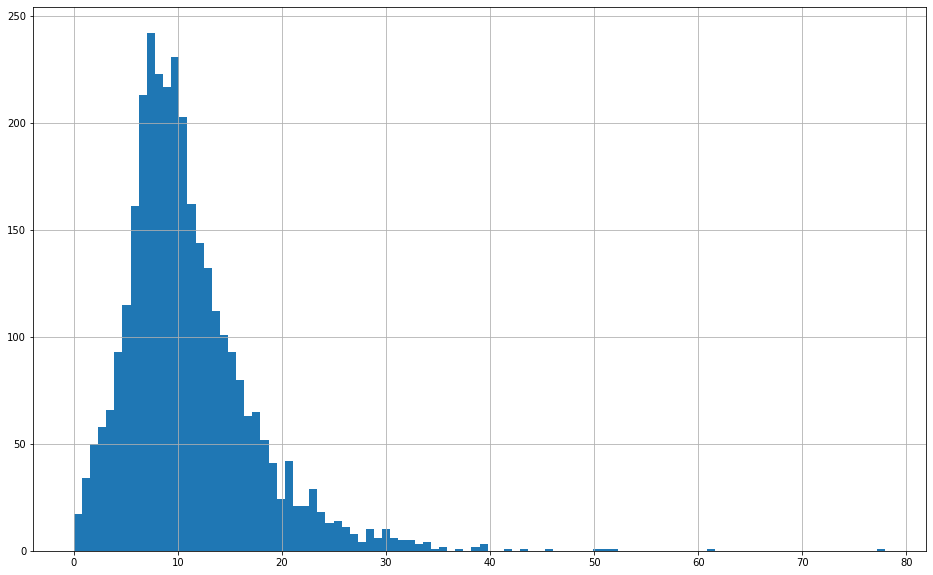

In [22]:
display(data_gas['Газ 1'].describe())
data_gas['Газ 1'].hist(bins=100, figsize=(16,10))

### Результаты измерения температуры

In [23]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [24]:
show_rows(data_temp)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Время замера
['2019-05-03 11:16:18' '2019-05-03 11:25:53' '2019-05-03 11:29:11' ...
 '2019-09-01 04:22:39' '2019-09-01 04:33:42' '2019-09-01 04:38:08']
Уникальные значения столбца Температура
[1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627. 1628. 1629. 1630. 1631. 1632. 1633. 

In [25]:
len(data_temp['key'].unique())


3216

In [26]:
data_temp['key'].value_counts()

46      16
1214    16
1513    16
44      16
1689    15
        ..
1415     2
1836     2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

<AxesSubplot:>

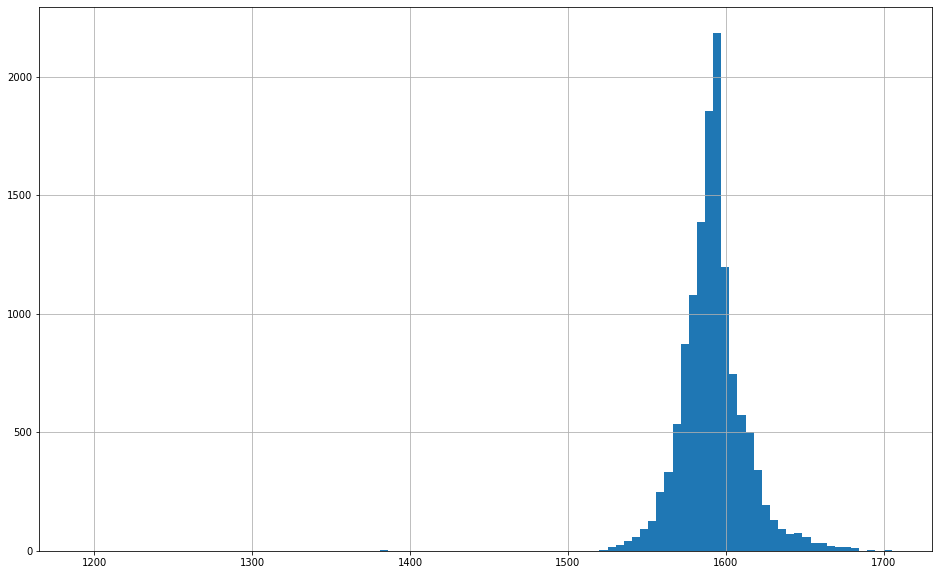

In [27]:
display(data_temp['Температура'].describe())
data_temp['Температура'].hist(bins=100, figsize=(16,10))

### Данные о проволочных материалах (объём)

In [28]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
show_rows(data_wire)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
[  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]
Уникальные значения столбца Wire 2
[3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 1.21430400e+

In [30]:
len(data_wire['key'].unique())

3081

In [31]:
data_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

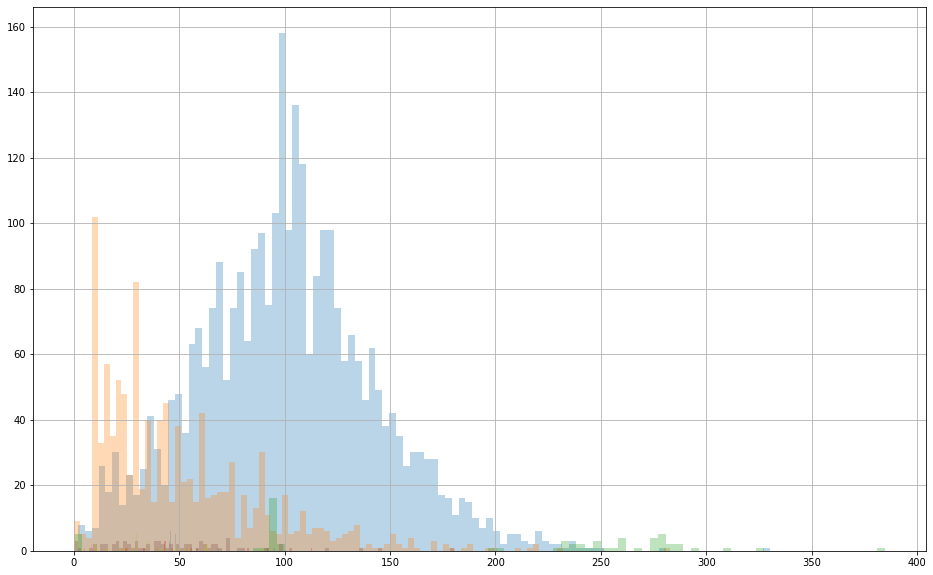

In [32]:
for column in data_wire.columns:
    if column[0] == 'W':
        print(column)
        display(data_wire[column].describe())
        data_wire[column].hist(bins=100, figsize=(16,10), alpha=0.3)

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>],
       [<AxesSubplot:title={'center':'Wire 3'}>,
        <AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>],
       [<AxesSubplot:title={'center':'Wire 6'}>,
        <AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>],
       [<AxesSubplot:title={'center':'Wire 9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

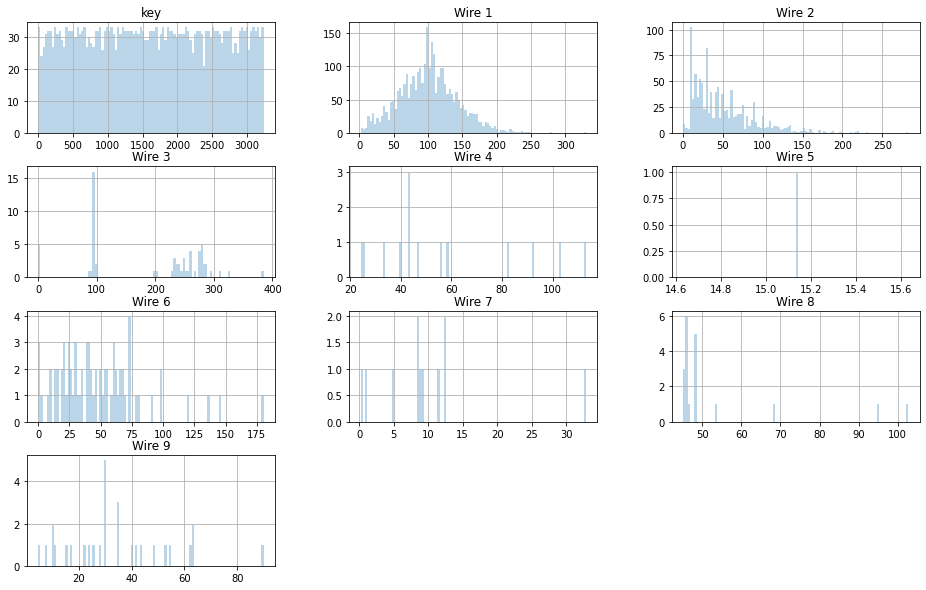

In [33]:
data_wire.hist(bins=100, figsize=(16,10), alpha=0.3)

### Данные о проволочных материалах (время)

In [34]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [35]:
show_rows(data_wire_time)

Уникальные значения столбца key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения столбца Wire 1
['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]
Уникальные значения столбца Wire 2
['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]
Уникальные значения столбца Wire 3
['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-08 17:20:59' '201

In [36]:
len(data_wire_time['key'].unique())

3081

In [37]:
data_wire_time['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

# Выводы по пункту 1

## Подготовка данных

-Найдем суммы значений активной и реактивной мощности

-Найдем все записи по температурам, где есть минимум два значения температуры и создадим новую таблицу из первого и последнего замера.

-Значения столбца key переведем в индексы датафреймов.

-Pаполним nan значения 0 для таблиц data_bulk и data_wire.

-Приведем типы данных для ускорения работы.

-Разобьем данные на train/test в соотношении 75/25.
-Составим из таблицы data_arc сгрупированную таблицу data_arc_sum по key для дальнейшего объединения данных. 

По факту, чем больше энергии было затрачено на нагрев, тем больше должна быть температура.

In [38]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


Удалим из таблицы партии key, которые не подходят по следующим условиям:

Нет финального замера. Когда температуру замеряли до окончания последней операции нагрева дугой
Только один замер температуры

In [39]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216] 171


Удалим все строки с пропусками.

In [40]:
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12381 non-null  int64  
 1   Время замера  12381 non-null  object 
 2   Температура   12381 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.9+ KB


In [41]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1214    16
1513    16
46      16
44      16
2108    15
        ..
1801     2
35       2
1894     2
2194     2
800      2
Name: key, Length: 2344, dtype: int64

In [42]:
data_temp.columns = ['key', 'time','temp']
pt_data_temp = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


Получен срез со значениями времени начального и конечного замера. Сформируем новый срез на основе времени и сохраним его в data_temp_final.

In [43]:
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [44]:
data_temp_final

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Для объединения нам потребуются датафреймы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице преобразуем index в значение столбца key.

In [45]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

In [46]:
data_steel = data_temp_final.copy()

In [47]:
data_steel = data_steel.merge(data_arc_sum, on='key')
data_steel.head()

,start_temp,end_temp,sum_active_power,sum_reactive_power
key,,,,
1,1571.0,1613.0,4.878147,3.183241
2,1581.0,1602.0,3.052598,1.998112
3,1596.0,1599.0,2.525882,1.599076
4,1601.0,1625.0,3.209250,2.060298
5,1576.0,1602.0,3.347173,2.252643


In [48]:
data_steel = data_steel.merge(data_bulk, on='key')
data_steel.head()

,start_temp,end_temp,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,1581.0,1602.0,3.052598,1.998112,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,1596.0,1599.0,2.525882,1.599076,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,1601.0,1625.0,3.209250,2.060298,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,1576.0,1602.0,3.347173,2.252643,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [49]:
data_steel = data_steel.merge(data_gas, on='key')
data_steel.head()

,start_temp,end_temp,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas
key,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986
2,1581.0,1602.0,3.052598,1.998112,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
3,1596.0,1599.0,2.525882,1.599076,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793
4,1601.0,1625.0,3.209250,2.060298,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
5,1576.0,1602.0,3.347173,2.252643,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692


In [50]:
data_steel = data_steel.merge(data_wire, on='key')
data_steel.head()

,start_temp,end_temp,sum_active_power,sum_reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,NaN,NaN,NaN,43.0,NaN,NaN,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1581.0,1602.0,3.052598,1.998112,NaN,NaN,NaN,73.0,NaN,NaN,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1596.0,1599.0,2.525882,1.599076,NaN,NaN,NaN,34.0,NaN,NaN,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1601.0,1625.0,3.209250,2.060298,NaN,NaN,NaN,81.0,NaN,NaN,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1576.0,1602.0,3.347173,2.252643,NaN,NaN,NaN,78.0,NaN,NaN,...,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_steel = data_steel.dropna(subset=['end_temp'])
data_steel.info()
data_steel = data_steel.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_temp          2210 non-null   float64
 1   end_temp            2210 non-null   float64
 2   sum_active_power    2210 non-null   float64
 3   sum_reactive_power  2210 non-null   float64
 4   bulk_1              189 non-null    float64
 5   bulk_2              13 non-null     float64
 6   bulk_3              926 non-null    float64
 7   bulk_4              756 non-null    float64
 8   bulk_5              53 non-null     float64
 9   bulk_6              428 non-null    float64
 10  bulk_7              13 non-null     float64
 11  bulk_8              1 non-null      float64
 12  bulk_9              13 non-null     float64
 13  bulk_10             130 non-null    float64
 14  bulk_11             124 non-null    float64
 15  bulk_12             1730 non-null   float64
 16  bulk_1

Наша цель - предсказывать значение end_temp. Удалим партии, где нет информации о температуре. Столбец wire_5 удалим из-за отсуствия информации во всех запясях.

In [52]:
#data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
#data_steel = data_steel.dropna(subset=['end_temp'])
#data_steel.info()
#data_steel = data_steel.drop('wire_5',axis=1)


Приведем типы столбцов start_temp, end_temp и bulk составляющих к целому типу, так как там храняться только целые числа. Заранее во все NaN разместим значения 0.

In [53]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_temp          2210 non-null   int16  
 1   end_temp            2210 non-null   int16  
 2   sum_active_power    2210 non-null   float64
 3   sum_reactive_power  2210 non-null   float64
 4   bulk_1              2210 non-null   int16  
 5   bulk_2              2210 non-null   int16  
 6   bulk_3              2210 non-null   int16  
 7   bulk_4              2210 non-null   int16  
 8   bulk_5              2210 non-null   int16  
 9   bulk_6              2210 non-null   int16  
 10  bulk_7              2210 non-null   int16  
 11  bulk_8              2210 non-null   int8   
 12  bulk_9              2210 non-null   int16  
 13  bulk_10             2210 non-null   int16  
 14  bulk_11             2210 non-null   int16  
 15  bulk_12             2210 non-null   int16  
 16  bulk_1

Изучим распределение данных.

<AxesSubplot:>

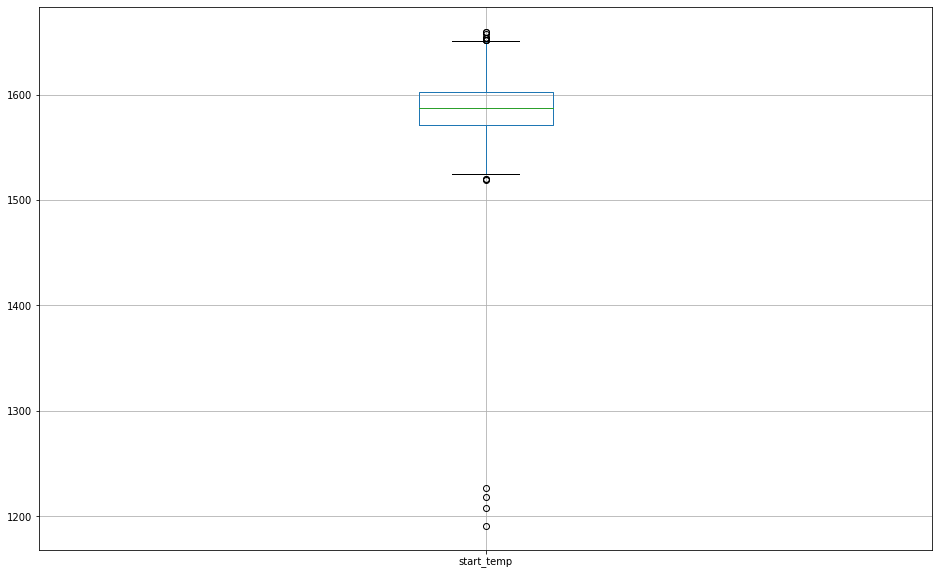

In [54]:
data_steel.boxplot(column='start_temp', figsize=(16,10))

При минимальной температуре плавления металлов 1400 градусов, отмечаются значения сильно ниже, определим их как выбросы и удалим.

In [55]:
data_steel = data_steel.query("start_temp > 1400")

<AxesSubplot:>

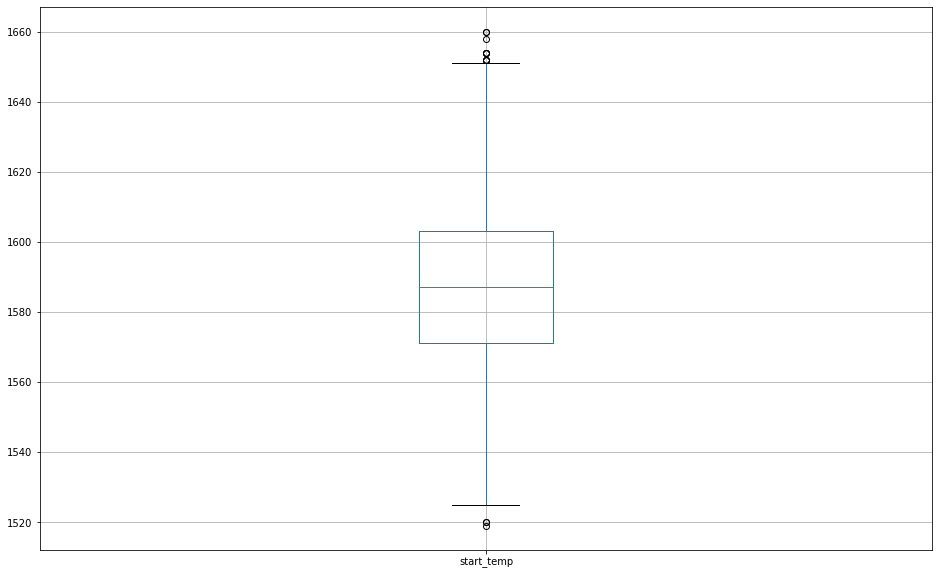

In [56]:
data_steel.boxplot(column='start_temp', figsize=(16,10))

<AxesSubplot:>

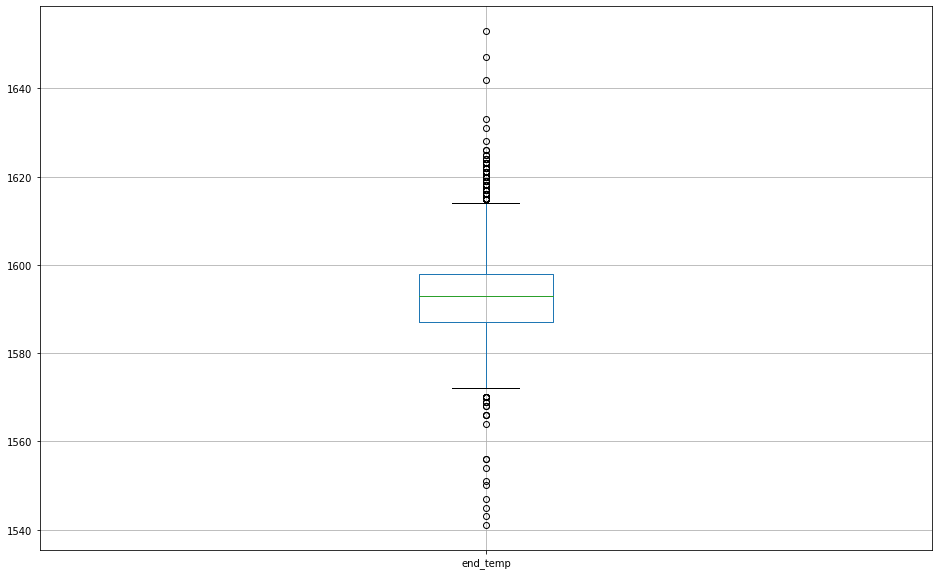

In [57]:
data_steel.boxplot(column='end_temp', figsize=(16,10))

<AxesSubplot:>

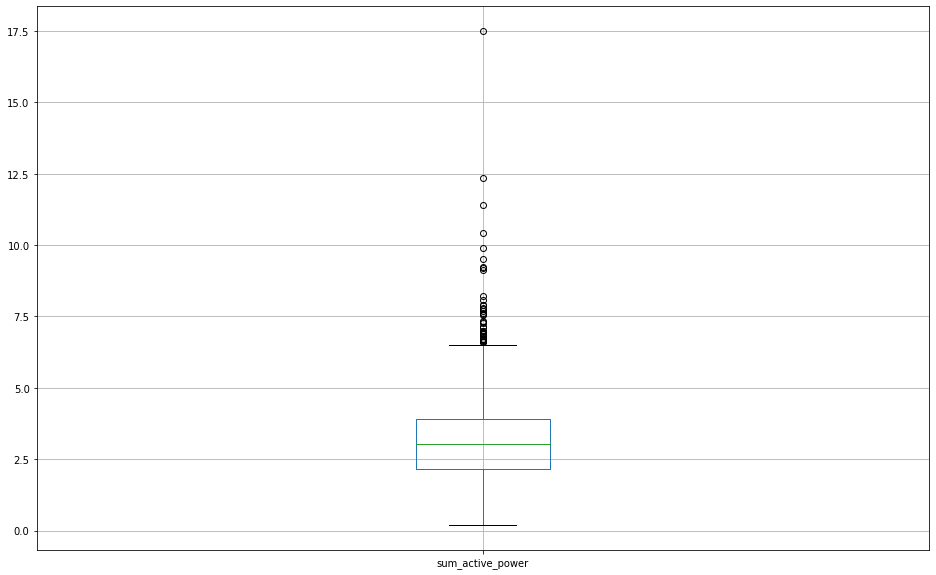

In [58]:
data_steel.boxplot(column='sum_active_power', figsize=(16,10))

<AxesSubplot:>

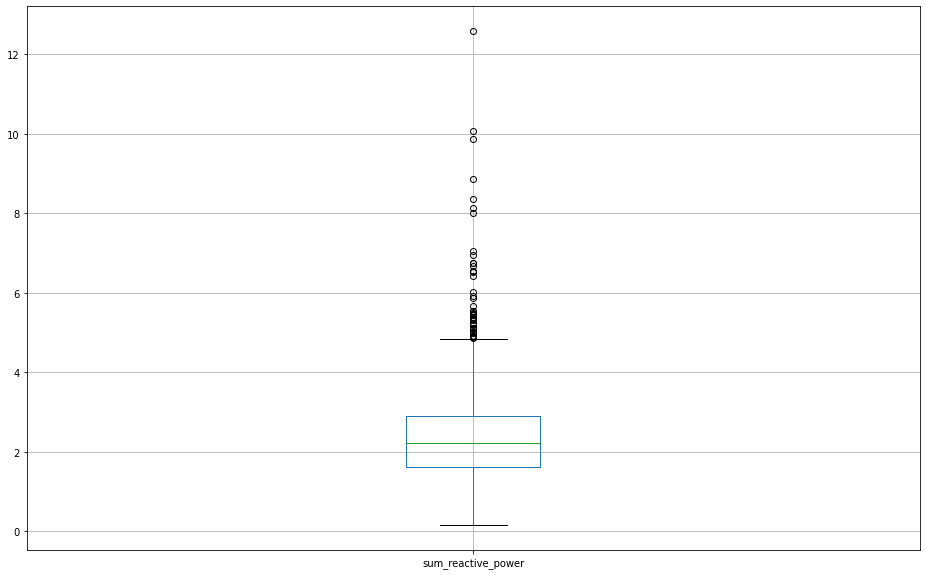

In [59]:
data_steel.boxplot(column='sum_reactive_power', figsize=(16,10))

<AxesSubplot:>

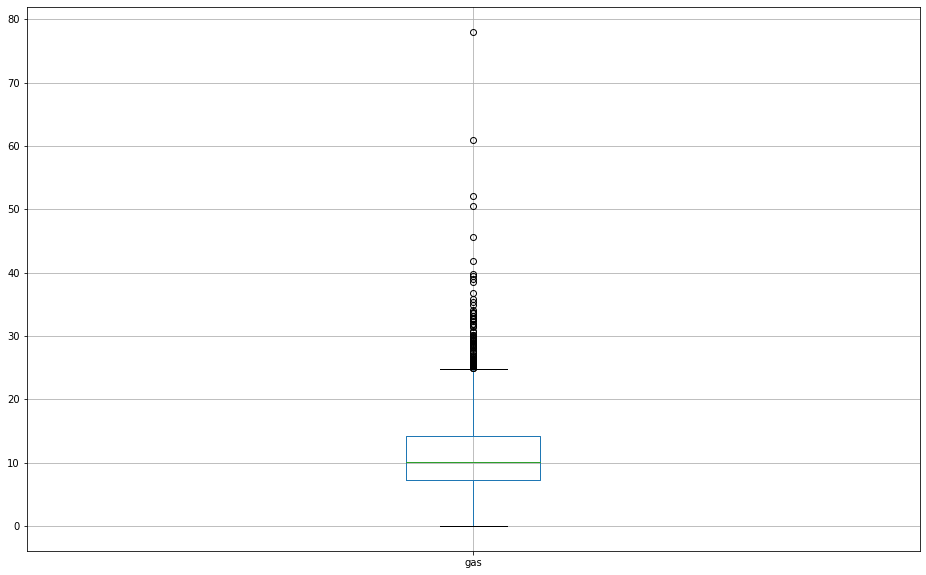

In [60]:
data_steel.boxplot(column='gas', figsize=(16,10))

Выполним оценку мультиколлинеарности и отсутствие зависимостей между целевым признаком и остальными.

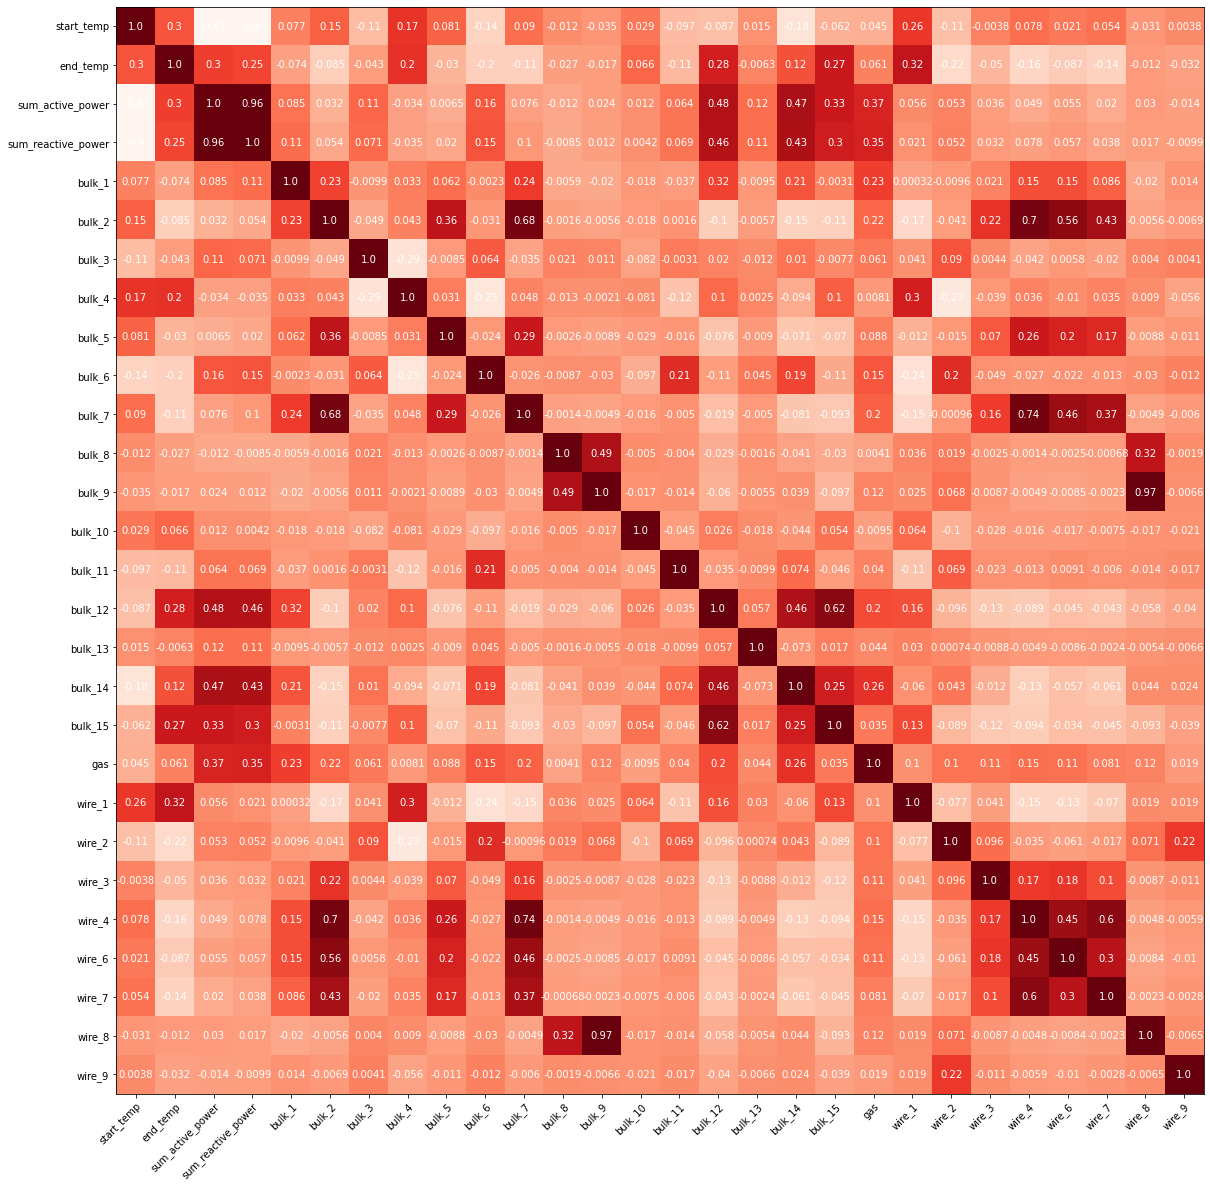

In [61]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Из heatmap видно что есть сильные прямопропоциональные зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Так как они дублируют по сути друг друга, удалим из обучения sum_reactive_power и wire_8.

In [62]:
data_steel_knn = data_steel_knn.drop(['sum_reactive_power', 'wire_8'], axis=1)

Оценим, какие столбцы влияют на результат end_temp.

In [63]:
data_steel_knn.corr()['end_temp'] 

start_temp          0.299206
end_temp            1.000000
sum_active_power    0.296610
bulk_1             -0.073801
bulk_2             -0.084997
bulk_3             -0.042944
bulk_4              0.195423
bulk_5             -0.030069
bulk_6             -0.199802
bulk_7             -0.110294
bulk_8             -0.027373
bulk_9             -0.017085
bulk_10             0.065518
bulk_11            -0.106140
bulk_12             0.275465
bulk_13            -0.006325
bulk_14             0.116793
bulk_15             0.271303
gas                 0.060722
wire_1              0.324132
wire_2             -0.221917
wire_3             -0.049670
wire_4             -0.163916
wire_6             -0.086973
wire_7             -0.140636
wire_9             -0.032042
Name: end_temp, dtype: float64

Как видно, не все столбцы значимо влияют на данные. Для выявления аномалий возьмем те, чья корреляция больше 10%

In [64]:
data_steel_knn.corr()['end_temp'].abs() >= 0.1

start_temp           True
end_temp             True
sum_active_power     True
bulk_1              False
bulk_2              False
bulk_3              False
bulk_4               True
bulk_5              False
bulk_6               True
bulk_7               True
bulk_8              False
bulk_9              False
bulk_10             False
bulk_11              True
bulk_12              True
bulk_13             False
bulk_14              True
bulk_15              True
gas                 False
wire_1               True
wire_2               True
wire_3              False
wire_4               True
wire_6              False
wire_7               True
wire_9              False
Name: end_temp, dtype: bool

In [65]:
data_steel_knn

,start_temp,end_temp,sum_active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,4.878147,0,0,0,43,0,0,0,...,150,154,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
2,1581,1602,3.052598,0,0,0,73,0,0,0,...,149,154,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
3,1596,1599,2.525882,0,0,0,34,0,0,0,...,152,153,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
4,1601,1625,3.209250,0,0,0,81,0,0,0,...,153,154,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
5,1576,1602,3.347173,0,0,0,78,0,0,0,...,151,152,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,3.210690,0,0,21,0,0,0,0,...,129,223,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0
2496,1554,1591,4.203064,0,0,0,63,0,0,0,...,129,226,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0
2497,1571,1589,2.212379,0,0,0,85,0,0,0,...,124,226,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0


# Выводы по пункту 2

Данные были подготовлены для обучения к модели. Целевым признаком является столбец end_temp. Остальные столбцы будут использованы для предсказания.

## Обучение модели


Разобьем данные на train и test к соотношению 75/25. Выберем количество кросс-валидаций равным 5.

In [67]:
random_state = 19042023
# features = data_steel.drop('end_temp', axis=1)
# target = data_steel['end_temp']

features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

Выберем следующие модели:

-LinearRegression

-RandomForestRegressor

-CatBoostRegressor

-LGBMRegressor

-XGBRegressor

### LinearRegression

In [68]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)

print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)



# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 6.144276250203047
CPU times: user 341 ms, sys: 473 ms, total: 814 ms
Wall time: 763 ms


### RandomForestRegressor

In [69]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]
# hyperparams = [{'criterion':['mse'],
#                 'n_estimators':[300], 
#                 'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)



# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 850, 'random_state': 19042023}

Grid scores on development set:

6.117957 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 19042023}
6.121555 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 19042023}
6.118221 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 19042023}
6.119773 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 19042023}
6.114017 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 19042023}
6.112280 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 19042023}
6.107713 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 19042023}
6.106456 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 19042023}
6.108604 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 19042023}
6.104127 for {'criterion': 'mse', 'n_estimators': 550, 'random_state': 

### CatBoostRegressor

In [70]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)



# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 5.943057490535574
CPU times: user 20 s, sys: 635 ms, total: 20.6 s
Wall time: 32.6 s


In [71]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR



{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 19042023,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04433099925518036,
 'score_function': 'Cosine',
 'tas

### LGBMRegressor

In [72]:
%%time

regressor = LGBMRegressor() 
#hyperparams = [{'num_leaves':[x for x in range(10,31)], 
#                'learning_rate':[x/100 for x in range(1, 11)],
#                'random_state':[random_state]}]
hyperparams = [{'num_leaves':[15], 
                 'learning_rate':[0.05],
                 'random_state':[random_state]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)



# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.05, 'num_leaves': 15, 'random_state': 19042023}

Grid scores on development set:

6.106712 for {'learning_rate': 0.05, 'num_leaves': 15, 'random_state': 19042023}

CPU times: user 21min 46s, sys: 14.5 s, total: 22min
Wall time: 22min 28s


### XGBRegressor

In [73]:
%%time

regressor = XGBRegressor() 
#hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
#                'random_state':[random_state],
#                 'silent':[True]}]
hyperparams = [{'num_leaves':[100], 
                 'learning_rate':[0.16],
                 'random_state':[random_state],
                  'silent':[True]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

[17:20:36] WARNING: ../src/learner.cc:576: 
Parameters: { "num_leaves", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:22:19] WARNING: ../src/learner.cc:576: 
Parameters: { "num_leaves", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:24:00] WARNING: ../src/learner.cc:576: 
Parameters: { "num_leaves", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

In [74]:

index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на CV
LinearRegression,6.144276
RandomForestRegressor,6.102784
CatBoostRegressor,5.943057
LGBMRegressor,6.106712
XGBRegressor,6.067251


# Вывод по пункту 3

Были выбраны и обучены модели для предсказания финальной температуры. Произведен поиск гиперпараметров для получения лучшего результата. Минимальное МАЕ показала модель LGBMRegressor. Проверим ее на тестовой выборке.

##  Тестирование моделей

Протестируем выбранную модель. Качественной оценкой будем считать выполнения двух условий:

-Минимальный показатель МАЕ < 8.7

-Иделаьный показатель МАЕ < 6.

In [75]:
#%%time

#model = LinearRegression()
#model.fit(features_train, target_train)
#target_predict = model.predict(features_test)
#test_MAE_LR = mean_absolute_error(target_predict, target_test)
#print('MAE on test for LinearRegression =', test_MAE_LR)

In [76]:
#%%time

#model = RandomForestRegressor()
#model.set_params(**best_params_RFR)
#model.fit(features_train, target_train)
#target_predict = model.predict(features_test)
#test_MAE_RFR = mean_absolute_error(target_predict, target_test)
#print('MAE on test of RandomForestRegressor =', test_MAE_RFR)

In [77]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.704055068561276
CPU times: user 3.5 s, sys: 131 ms, total: 3.63 s
Wall time: 5.25 s


Построим график отображающий важность признаков:

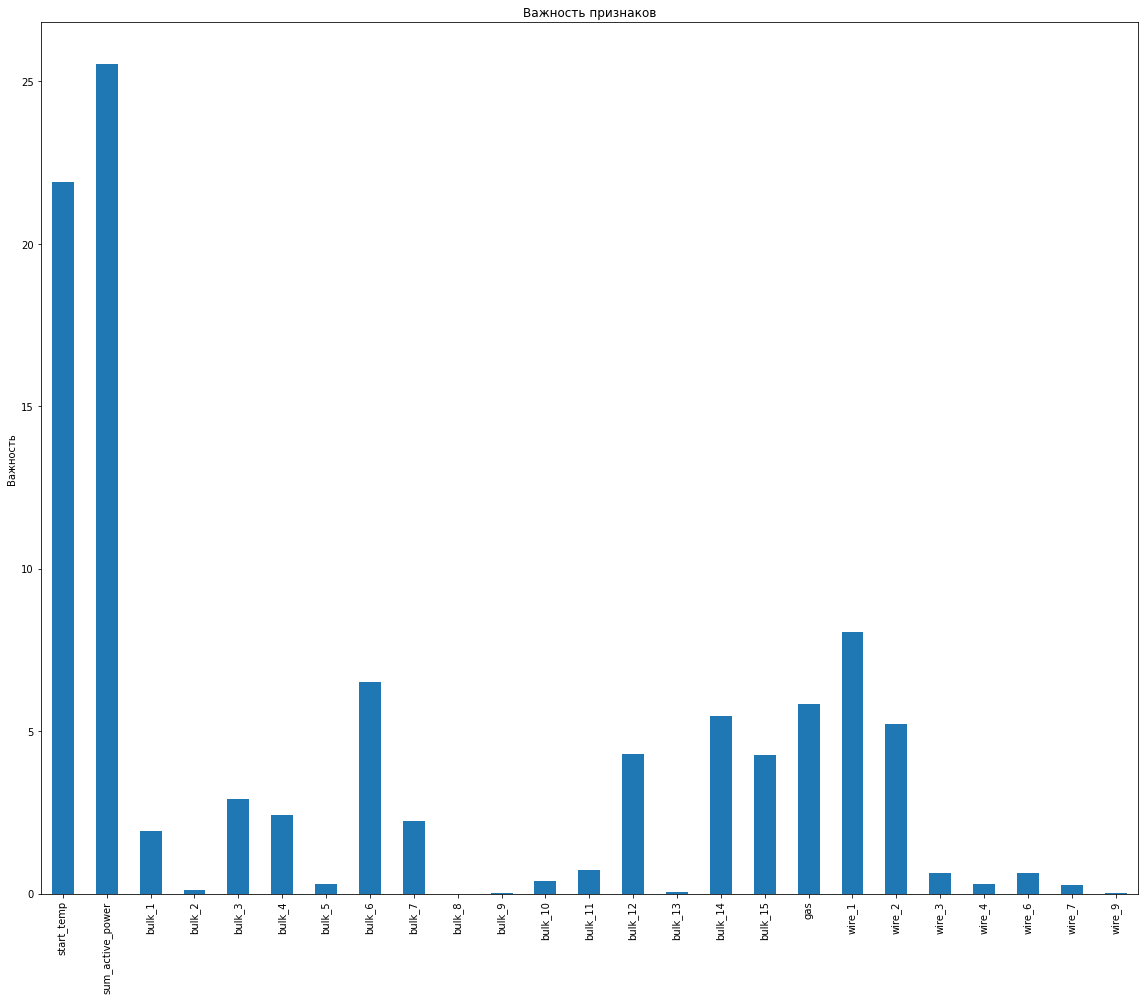

In [78]:
imp = pd.Series(model.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

На лицо два наиболее важных признака.

In [79]:
#%%time

#model = LGBMRegressor()
#model.set_params(**best_params_LGBMR)
#model.fit(features_train, target_train)
#target_predict = model.predict(features_test)
#test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
#print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

In [80]:
#%%time
#
#model = XGBRegressor()
#model.set_params(**best_params_XGBR)
#model.fit(features_train, target_train)
#target_predict = model.predict(features_test)
#test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
#print('MAE on test of XGBRegressor =', test_MAE_XGBR)

In [81]:
#index = ['LinearRegression',
#         'RandomForestRegressor',
#         'CatBoostRegressor',
#         'LGBMRegressor',
#         'XGBRegressor']
#data = {'MAE на CV':[cv_MAE_LR,
#                     cv_MAE_RFR,
#                     cv_MAE_CBR,
#                     cv_MAE_LGBMR,
#                     cv_MAE_XGBR],
#        'MAE на тесте':[test_MAE_LR,
#                        test_MAE_RFR,
#                        test_MAE_CBR,
#                        test_MAE_LGBMR,
#                        test_MAE_XGBR]}
#
#scores_data = pd.DataFrame(data=data, index=index)
#scores_data['Выполнение минимальной задачи'] = scores_data['MAE на тесте'] <= 8.7
#scores_data['Выполнение идеальной задачи'] = scores_data['MAE на тесте'] <= 6
#scores_data

## Итоговый вывод

В ходе работы над проектом было выполнено:

-Подготовлены данные. Изменены типы данных; определены и использованы номера партий, у которых есть замеры по температуре.

-Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер в серии замеров. Разделены на features и target со смешиванием данных.

-Выбраны модели. Использованы и обучены регрессионные модели.

-Наилучший результат на тренировочной выборке показала модель CatBoostRegressor, МАЕ 5.5.589502

-Оценена эффективность CatBoostRegressor на тестовой выборке -5.67922.

Лучшей моделью по метрике MAE = 5.67922 стал CatBoostRegressor. Этот результат показывает, что модель в среднем ошибается на 5-6 градусов температуры. 